In [1]:
!nvidia-smi

Thu May 13 01:30:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   63C    P0    36W / 250W |      4MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [2]:
import pandas as pd
import pickle
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from enum import Enum
from torch.nn import functional as F
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

logger = logging.getLogger(__name__)
random.seed(13)

# Utilities

In [3]:
def pytorch_cos_sim(a: torch.Tensor, b: torch.Tensor):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    This function can be used as a faster replacement for 1-scipy.spatial.distance.cdist(a,b)
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

In [4]:
def nan_to_None(qr:pd.DataFrame,col:str):
    a = qr[col].tolist()
    for i in range(0,len(a)):
        if(type(a[i])!=list):
            a[i] = None
    qr[col] = a
    return qr

In [5]:
def string_sentence(i,qr):
    return qr.loc[i,'Title'] + ' '  + ' '.join(qr.loc[i,'Tags']) + ' '  + qr.loc[i,'Text']

# Model Hyper-Parameters

In [6]:
folder_quora = '/home/ckm/visualqatickets/superuser/Data'
folder = '.'
img_dir = folder_quora+'/'
os.makedirs(folder,exist_ok = True)
BATCH_SIZE = 8
fin_BATCH_SIZE = 32
n_worker = 8
margin  = 0.9
#---------
#Note that amp cannot be used without sigmoid
use_amp = False
use_sig = True # For BCEloss
#----------

# eval_BATCH_SIZE = 4 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Creating Dataset and Dataloader

### Loading Data

In [7]:
with open(folder_quora+'/pandas/split.txt','rb') as a:
    train_qr=pickle.load(a)
    dev_qr = pickle.load(a)
    test_qr = pickle.load(a)

In [8]:
with open(folder_quora+'/pairs_related/train_dev_test.txt','rb') as a:
    train_data=pickle.load(a)
    train_score = pickle.load(a)
    dev_data = pickle.load(a)
    dev_score = pickle.load(a)
    test_data = pickle.load(a)
    test_score = pickle.load(a)

In [9]:
with open(folder_quora+'/pairs_related/data_pos_neg.txt','rb') as a:
    train_data_pos = pickle.load(a)
    train_data_neg = pickle.load(a)
    dev_data_pos = pickle.load(a)
    dev_data_neg = pickle.load(a)
    test_data_pos = pickle.load(a)
    test_data_neg = pickle.load(a)

In [10]:
train_qr = nan_to_None(train_qr,'Attachments')
dev_qr = nan_to_None(dev_qr,'Attachments')
test_qr = nan_to_None(test_qr,'Attachments')
qr = pd.concat([train_qr,dev_qr,test_qr])

### Creating Dataset 

In [11]:
from PIL import Image
from torchvision import transforms
transform_pipe = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
from transformers import BertTokenizerFast, BertConfig,BertModel
config = BertConfig()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [13]:
class custom_dataset(Dataset):
    def __init__(self,qr,qr_idx,img_dir,label,transform = transform_pipe):
        self.qr = qr
        self.qr_idx = qr_idx
        self.img_dir = img_dir
        self.label = label
        self.transform = transform

    def image_adder(self,id1):
        img_id1 = list()
        if((self.qr.at[id1,'Attachments'])!=None):
            for i in self.qr.at[id1,'Attachments']:
                try:
                    img_path = os.path.join(self.img_dir,i)
                    img = Image.open(img_path).convert('RGB')
                    if(self.transform):
                        img = self.transform(img)
                        # print(img.shape)
                        if(img.shape==(224,224,3)):
                            img.permute(2,0,1)
                        # img = img.permute(2,0,1)
                        if(img.shape!=(3,224,224)):
                            print(f'something wrong with image transformation id: {id1} image shape: {img.shape}')
                    img_id1.append(img)
                except Exception as e: 
                    print(e)
        else:
            img_id1.append(torch.randn(3,224,224))

        # Work on this, for few examples, it is still saying list index out of range
        if(len(img_id1)==0):
            # print('No attachments found for id {}'.format(id1))
            print(f'Something went wrong with the image of id {id1}')
            img_id1.append(torch.randn(3,224,224))

        return img_id1
    
    def __getitem__(self,idx):
        id1 = self.qr_idx[idx][0]
        id2 = self.qr_idx[idx][1]
        img_id1 = self.image_adder(id1)
        img_id2 = self.image_adder(id2)

        # print(len(img_id1))

        # print('Printing id1 {} and len {} and id2 {} and len {} '.format(
        #     id1,len(img_id1),
        #     id2, len(img_id2)
        # ))

        # print('Printing id1 shape {} and id2  shape {}'.format(
        #     img_id1[0].shape,
        #     img_id2[0].shape
        # ))        

        sample = {
            'image': [img_id1[0],img_id2[0]]    #Currently taking only one input image
        }

        t1 = self.qr.loc[id1,'Title'] + ' ' + ' '.join(self.qr.loc[id1,'Tags']) + ' ' + self.qr.loc[id1,'Text']
        t2 = self.qr.loc[id2,'Title']+ ' ' + ' '.join(self.qr.loc[id2,'Tags']) + ' ' + self.qr.loc[id2,'Text']
        indexed_t1 = tokenizer.encode(t1,max_length = 350,truncation = True)
        indexed_t2 = tokenizer.encode(t2,max_length = 350,truncation = True)

        while(len(indexed_t1)<350):
            indexed_t1.append(0)
        while(len(indexed_t2)<350):
            indexed_t2.append(0)

        ten_t1 = torch.tensor(indexed_t1)[:512]
        ten_t2 = torch.tensor(indexed_t2)[:512]

        label_cos = self.label[idx]
        if(label_cos==0.0):
            label_cos = -1.0


        try:
            sample["label"] = self.label[idx]
            sample["token"] = [ten_t1,ten_t2] # torch.Size([batch_size, 512])
            sample["label_cos"] = label_cos 
        except Exception as e:
            print(e)
        
        return sample

    def __len__(self):
        return len(self.label)

## Train, dev and test dataloader

In [14]:
train_dataset = custom_dataset(train_qr,
                               train_data,
                               img_dir,
                               train_score,
                               transform = transform_pipe)

In [15]:
train_dataset[3]['image'][0].shape == (3,224,224)

True

In [16]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
    )

In [17]:
dev_dataset = custom_dataset(pd.concat([train_qr,dev_qr]),
                             dev_data,
                             img_dir,
                             dev_score,
                             transform = transform_pipe)

In [18]:
dev_loader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
    )

In [19]:
test_dataset = custom_dataset(pd.concat([train_qr,test_qr]),
                              test_data,
                              img_dir,
                              test_score,
                              transform = transform_pipe)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    drop_last = True
    )

# Model

## Loading Model 

In [21]:
from torchvision import models
res50 = models.resnet50(pretrained = True)
res50 = res50.to(device)
for param in res50.parameters():
    param.requires_grad = True
# res50.eval()

bert = BertModel.from_pretrained('bert-base-uncased')
bert = bert.to(device)
for param in bert.parameters():
    param.requires_grad = True
# bert.eval()

for param in bert.embeddings.parameters():
    param.requires_grad = False

for param in bert.encoder.layer[0].parameters():
    param.requires_grad = False

for param in res50.layer1.parameters():
    param.requires_grad = False

for param in res50.layer2.parameters():
    param.requires_grad = False



In [22]:
def get_activation(name, activation):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

## Final 2d attention

In [23]:
import math
class Final2d(torch.nn.Module):
    """ Custom Linear layer for equation (9) in paper --> 2D intra attention layer""" 
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.Tensor(size_out, size_in)
        self.weights = torch.nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.

        # initialize weights and biases
        torch.nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weights)

    def forward(self, x, a):
        # x.shape = batch_size, 768, 119
        # a.shape = batch_size, 119
        n = x.shape[2]
        h_cap = torch.zeros(x.shape[0], x.shape[1], device = device)
        # for k in range(x.shape[0]):
        #     for i in range(n):
        #         h_cap[k] = h_cap[k] + a[k][i]*torch.matmul(self.weights, x[k, :,i])
        z = torch.matmul(self.weights, x)
        for k in range(x.shape[0]):
            h_cap[k] = torch.sum(a[k, :]*z[k, :, :], dim = 1)
        return h_cap

## Mask

In [24]:
# n_val = 463+49 #360 is the text input vector length, and 49 is the image vector length
# sz = (BATCH_SIZE, n_val*n_val, 1)
# mask = torch.zeros(sz, dtype=torch.bool, device = device)
# for i in range(n_val):
#     mask[:, i*n_val+i] = 1
        
# for i in range(463-1, n_val):
#     for j in range(463-1, n_val):
#         mask[:, i*n_val+j] = 1

## Bridge Model

In [25]:
class BridgeModel(torch.nn.Module):
    # define model elements
    def __init__(self):
        super(BridgeModel, self).__init__()
        # input to first hidden layer
        self.activation = {}
        self.res50 = res50.to(device)
        self.res50.layer4[2].relu.register_forward_hook(get_activation('conv1', self.activation))
        self.res50.avgpool.register_forward_hook(get_activation('conv2', self.activation))
        self.bridge_seven_conv = torch.nn.Conv2d(in_channels=2048, out_channels=768, kernel_size=1, stride=1, padding = 0)
        self.bridge_one_conv = torch.nn.Conv2d(in_channels=2048, out_channels=768, kernel_size=1, stride=1, padding = 0)
        self.flatten = torch.nn.Flatten(start_dim = 2)
        self.bert = bert.to(device)
        self.mod_v = 463 #Overall text token length
        self.linear_2d = torch.nn.Linear(768*2, 1)
        self.soft_2d = torch.nn.Softmax(dim = 1)
        self.final_2d = Final2d(768, 768) #2D intra attention layer
        self.fc = torch.nn.Linear(768, 768)

    # forward propagate input
    def forward(self, X1, X2):
        # input to first hidden layer/
        res_out = self.res50(X1)  # torch.Size([batch_size, 1000])
        seven_conv = self.activation['conv1'] # torch.Size([batch_size, 2048, 7, 7])
        one_conv = self.activation['conv2'] # torch.Size([batch_size, 2048, 1, 1])
        out3 = one_conv # torch.Size([batch_size, 2048, 1, 1])
        out3 = out3[:, :, 0, 0].clone()
        seven_conv = self.bridge_seven_conv(seven_conv)  # torch.Size([batch_size, 768, 7, 7])
        one_conv = self.bridge_one_conv(one_conv)  # torch.Size([batch_size, 768, 1, 1])
        seven_conv = self.flatten(seven_conv) # torch.Size([batch_size, 768, 49])
        one_conv = self.flatten(one_conv) # torch.Size([batch_size, 768, 1])
        bridge_cat_temp = torch.cat((one_conv, seven_conv), dim = 2) # torch.Size([1, 768, 50])
        bridge_cat = bridge_cat_temp.permute(0, 2, 1) # torch.Size([1, 50, 768])
        bert_embed = self.bert.embeddings(input_ids = X2) # torch.Size([1, 512, 768])
        bert_embed = bert_embed[:,:self.mod_v,:]
        prev = torch.cat((bert_embed, bridge_cat), dim = 1) #562
        prev2 = prev[:, self.mod_v:, :]
        
        for i in range(12):
            part1 = self.bert.encoder.layer[i](prev)[0] # torch.Size([1, 562, 768])
            part2 = torch.matmul(part1[:, self.mod_v:, :], self.bert.encoder.layer[i].attention.self.value.weight)
            part1 = part1[:, :self.mod_v, :] # torch.Size([1, 512, 768])
            part1 = torch.cat((part1, part2), dim = 1)
            prev = part1
            prev2 = prev[:, self.mod_v:, :]

        # Mean Pooling
        # out1 = torch.mean(prev,dim=1) #[BATCH_SIZE,768]

        # Taking CLS token only
        out1 = prev[:,0,:]
            
        # out1 = prev[:, 0, :]
        # prev = prev[:, 1:, :]
        
        # n = self.mod_v + 49 # length(n) = |v| + |g| 
        # hij = torch.zeros(prev.shape[0], n*n, 2*prev.shape[2], device = device) # batch_size, 119*119=14161, 768+768
        # # for k in range(prev.shape[0]):
        # #    for i in range(n):
        # #        for j in range(n):
        # #            hij[k][i*n+j] = torch.cat((prev[k][i], prev[k][j]), dim = 0)

        # prev_repeat1 =  prev.repeat(1, n, 1) 
        # prev_repeat2 = torch.repeat_interleave(prev, repeats = n, dim = 1)
        # hij = torch.cat((prev_repeat1, prev_repeat2), dim = 2)

        # sij = self.linear_2d(hij) # batch_size, 14161, 1
        
        # # aij = self.soft_2d(sij) # batch_size, 14161, 1
        
        # sij[mask] = -1000

        # aij_tmp = self.soft_2d(sij) # batch_size, 14161, 1

        # aij = aij_tmp.reshape(aij_tmp.shape[0], n, n) # batch_size, n, n
        
        # ai_cap = torch.zeros(prev.shape[0], n, device = device) # batch_size, n
        
        # ai_cap = (torch.sum(aij, dim = 1) + torch.sum(aij, dim = 2))/2
        
        # #for k in range(prev.shape[0]):
        #  #   for i in range(n):
        #   #      for j in range(n):
        #    #         ai_cap[k][i] = ai_cap[k][i] + aij[k][i*n+j][0]/2
        #     #        ai_cap[k][i] = ai_cap[k][i] + aij[k][j*n+i][0]/2
        
        # new_hi = prev.permute(0, 2, 1)
        # out2 = self.final_2d(new_hi, ai_cap) # torch.Size([batch_size, 768])
        
        # out = torch.cat((out1,out3), dim = 1) # torch.Size([batch_size, 2048+768+768])
        
        out = self.fc(out1) # torch.Size([batch_size, 1])
        # yhat = self.sigm(out)
        # yhat = yhat[:, 0]
        # # print("Activation dict len : " + str(len(self.activation)))
        return out

    def mask_creation(batch):
        n_val = 463+49 #360 is the text input vector length, and 49 is the image vector length
        sz = (batch, n_val*n_val, 1)
        mask = torch.zeros(sz, dtype=torch.bool, device = device)
        for i in range(n_val):
            mask[:, i*n_val+i] = 1
                
        for i in range(463-1, n_val):
            for j in range(463-1, n_val):
                mask[:, i*n_val+j] = 1
        return mask

In [26]:
model = BridgeModel().to(device)

# Losses

## Multiple Negative Ranking loss

In [27]:
class negrankloss():
    def __init__(self,scale: float = 20.0):
        # self.cosine_sim = nn.CosineSimilarity()
        self.scale = scale
        self.cross_entropy = nn.CrossEntropyLoss()

    def cal_loss(self,emb1: torch.Tensor,emb2: torch.Tensor, labels: torch.Tensor):
        scores  = pytorch_cos_sim(emb1,emb2) *self.scale
        # print(f'The scores of cosine similarity for MNRloss is {scores}')
        labels = torch.tensor(range(len(scores)), dtype=torch.long, device=scores.device)
        loss = self.cross_entropy(scores, labels)
        return loss

In [28]:
MNRloss = negrankloss()

## Online Constrantive Loss


In [29]:
class SiameseDistanceMetric(Enum):
    """
    The metric for the contrastive loss
    """
    EUCLIDEAN = lambda x, y: F.pairwise_distance(x, y, p=2)
    MANHATTAN = lambda x, y: F.pairwise_distance(x, y, p=1)
    COSINE_DISTANCE = lambda x, y: 1-F.cosine_similarity(x, y)


In [30]:
class OnlineConstrantiveLoss():
    def __init__(self,distance_metric=SiameseDistanceMetric.COSINE_DISTANCE,margin: float = 0.5):
        self.distance_metric = distance_metric
        self.margin = margin

    def cal_loss(self,emb1,emb2,labels,size_average=False):
        distance_matrix = self.distance_metric(emb1,emb2)
        # print(f'distance matrix of OCloss is {distance_matrix}')
        negs = distance_matrix[labels == 0]
        poss = distance_matrix[labels == 1]
        # print(f'positive and negatives are {poss} and {negs}')

        # select hard positive and hard negative pairs
        negative_pairs = negs[negs < (poss.max() if len(poss) > 1 else negs.mean())]
        positive_pairs = poss[poss > (negs.min() if len(negs) > 1 else poss.mean())]

        negative_pairs = negs
        positive_pairs = poss

        # print(f'positive and negative pairs are {positive_pairs} and {negative_pairs}')

        positive_loss = positive_pairs.pow(2).sum()
        negative_loss = F.relu(self.margin - negative_pairs).pow(2).sum()
        # print(f'positive loss is {positive_loss} and negative loss is {negative_loss}')
        loss = positive_loss + negative_loss
        return loss
    

In [31]:
OCloss = OnlineConstrantiveLoss(margin = margin)

## Cross Entropy Loss

In [32]:
class crossentropy():
    def __init__(self):
        self.cross_entropy = nn.BCELoss()
        self.cos_sim =  nn.CosineSimilarity(dim=1,eps=1e-6)
        self.sig = nn.Sigmoid()
        self.BCE_with_sig = nn.BCEWithLogitsLoss()
    
    def cal_loss(self,emb1:torch.Tensor,emb2:torch.Tensor,label:torch.Tensor):
        sim = (self.cos_sim(emb1,emb2))

        if(use_sig == True):
            loss = self.BCE_with_sig(sim,label)
        else:
            sim[sim<0] = 0
            loss = self.cross_entropy(sim,label)
        return loss

In [33]:
BCEloss = crossentropy()

## Cosine Similarity Loss

In [34]:
class cos_sim():
    def __init__(self):
        self.cossim = nn.CosineEmbeddingLoss()

    def cal_loss(self,emb1,emb2,target):
        loss = self.cossim(emb1,emb2,target)
        return loss

In [35]:
Cosloss = cos_sim()

# Evaluators: AUC(0.05) and Binary accuracy

In [36]:
import sklearn.metrics as skm

In [37]:
class AUC():
    def __init__(self,max_fpr:float = 0.05):
        self.max_fpr = 0.05
        self.cos_sim =  nn.CosineSimilarity(dim=1,eps=1e-6)
        self.sig = nn.Sigmoid()

    def cal(self,model:BridgeModel,loader:DataLoader):
        y_pred = []
        y_true = []
        y_pred_sig = []
        start = time.time()
        model.eval()
        for i,batch in enumerate(loader):
            with torch.no_grad():
                images = batch["image"]
                label = batch["label"]
                label = label.float()
                token = batch["token"]

                images[0],images[1] = images[0].to(device),images[1].to(device)
                token[0],token[1] = token[0].to(device), token[1].to(device)
                label = label.to(device)
            
                # compute the model output
                yhat1 = model(images[0], token[0])
                yhat2 = model(images[1],token[1])

                if(i%1000==0):
                    print(f'    {i} iterations have been done in {time.time()-start} seconds')

                sim = (self.cos_sim(yhat1,yhat2))
                a=self.sig(sim)
                a[a>0.5] = 1
                a[a<0.5] = 0

                y_pred_sig.append(a.cpu().numpy())
                y_pred.append(sim.cpu().numpy())
                y_true.append(label.cpu().numpy())

                del  label, token,yhat1,yhat2,sim,a,images 
        
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()
        y_pred_sig = np.array(y_pred_sig).flatten()
        Bin_score = skm.accuracy_score(y_true,y_pred_sig) 
        AUC_score = skm.roc_auc_score(y_true,y_pred,max_fpr = self.max_fpr)
        conf_matrix = skm.confusion_matrix(y_true,y_pred_sig)
        plt.hist(y_pred,bins='auto')
        plt.show()
        return AUC_score,Bin_score,conf_matrix

In [38]:
AUC_evaluator = AUC()

# Calculating loss and executing

In [39]:
save_dir = folder + '/model_state_dict'
os.makedirs(save_dir,exist_ok = True)

In [40]:
from torch.optim import Adam
from torch.nn import BCELoss
import time
import copy
from transformers import get_linear_schedule_with_warmup

def train_model(train_loader, model,num_epochs):
    model.train()

    since = time.time()

    optimizer = Adam(model.parameters(), lr=1e-4)
    optimizer = Adam([{'params': model.res50.parameters(), 'lr': 4e-6},
                      {'params': model.bert.parameters(), 'lr': 4e-6}
                      ], lr=4e-4)
    train_steps = num_epochs
    
    best_acc = 0.0

    acc_steps = fin_BATCH_SIZE/BATCH_SIZE

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    cos_sim = nn.CosineSimilarity(dim=1,eps=1e-6)
    sig = nn.Sigmoid()

    #Clipping grads
    torch.nn.utils.clip_grad_value_(model.parameters(),-1)

    # model.eval()
    # Evaluating on dev loader
    # print('Running dev_evaluator for 2000 samples i.e. 1000 iterations. Time taken: 5 min')
    # a,b,c = AUC_evaluator.cal(model,dev_loader)
    # print(f'AUC score is {a}  while binary score is {b} and the confusion matrix is {c} on dev loader before training')

    # enumerate epochs
    for epoch in range(num_epochs):
        model.train()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        running_OCloss = 0.0
        running_MNRloss = 0.0
        running_BCEloss = 0.0
        running_Cosloss = 0.0

        model.zero_grad()
        optimizer.zero_grad()

        y_pred = []
        y_true = []
        y_pred_sig = []

        for i, batch in enumerate(train_loader):
            model.train()

            with torch.cuda.amp.autocast(enabled=use_amp):
                
                if(i%50000 == 0 and i!=0):
                    model.eval()
                    print('Running dev_evaluator for 2000 samples i.e. 1000 iterations. Time taken: 5 min')
                    a,b,c = AUC_evaluator.cal(model,dev_loader)
                    print(f'AUC score is {a}  while binary score is {b} and the confusion matrix is {c} on dev loader')
                    torch.save(model.state_dict(), save_dir+'/multimodal_cos.bin')
                    print(f'Model is saved after {i} iterations ')
                    model.train()
        
                images = batch["image"]
                label = batch["label"]
                label = label.float()
                token = batch["token"]
                label_cos = batch['label_cos']
                
                images[0],images[1] = images[0].to(device),images[1].to(device)
                token[0],token[1] = token[0].to(device), token[1].to(device)
                label = label.to(device)
                label_cos = label_cos.to(device)
                
                yhat1= model(images[0],token[0])
                yhat2 = model(images[1],token[1])

                sim = (cos_sim(yhat1,yhat2))
                a=sig(sim)
                a[a>=0.5] = 1
                a[a<0.5] = 0

                y_pred_sig.append(a.detach().cpu().numpy())
                y_pred.append(sim.detach().cpu().numpy())
                y_true.append(label.detach().cpu().numpy())

                # yhat1_pos = model(pos_token[0])
                # yhat2_pos = model(pos_token[1])
                
                BCEloss_val = BCEloss.cal_loss(yhat1,yhat2,label)
                running_BCEloss += BCEloss_val.item()*BATCH_SIZE
                BCEloss_val = BCEloss_val/acc_steps

                # MNRloss_val = MNRloss.cal_loss(yhat1_pos,yhat2_pos)
                # running_MNRloss += MNRloss_val.item()*BATCH_SIZE
                # MNRloss_val = MNRloss_val/acc_steps

                OCloss_val = OCloss.cal_loss(yhat1,yhat2,label)
                running_OCloss +=  OCloss_val.item()*BATCH_SIZE
                OCloss_val = OCloss_val/acc_steps

                Cosloss_val = Cosloss.cal_loss(yhat1,yhat2,label_cos)
                running_Cosloss += Cosloss_val.item()*BATCH_SIZE
                Cosloss_val = Cosloss_val/acc_steps
            
            scaler.scale(Cosloss_val).backward(retain_graph = True)
            scaler.scale(BCEloss_val).backward(retain_graph = True)
            # scaler.scale(MNRloss_val).backward(retain_graph=True)
            scaler.scale(OCloss_val).backward()

            if((i+1)%acc_steps==0):
                scaler.step(optimizer)
                scaler.update()
                model.zero_grad()
            
            if(i%10000 == 0 ):
                print('OCloss is {} and BCEloss is {} and MNRloss is {} and Cosloss is {}  and time taken is {} after {} iterations'.format(
                    running_OCloss/((i+1)*BATCH_SIZE),
                    running_BCEloss/((i+1)*BATCH_SIZE),
                    running_MNRloss/((i+1)*BATCH_SIZE),
                    running_Cosloss/((i+1)*BATCH_SIZE),
                    time.time()-since,
                    i))
            
            del  yhat1,yhat2, label, token, images,Cosloss_val,label_cos,BCEloss_val,OCloss_val

        epoch_OC = running_OCloss / len(train_dataset)
        epoch_BCE = running_BCEloss / len(train_dataset)
        epoch_MNR = running_MNRloss / len(train_dataset)
        epoch_Cos = running_Cosloss/len(train_dataset)
        print(f'{epoch+1} Epoch completed. OCloss is {epoch_OC} and BCEloss is {epoch_BCE} and MNRloss is {epoch_MNR} and Cosloss is {epoch_Cos}')
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()
        y_pred_sig = np.array(y_pred_sig).flatten()
        Bin_score = skm.accuracy_score(y_true,y_pred_sig) 
        AUC_score = skm.roc_auc_score(y_true,y_pred,max_fpr = 0.05)
        conf_matrix = skm.confusion_matrix(y_true,y_pred_sig)
        plt.hist(y_pred,bins='auto')
        plt.show()
        print(f'AUC and Bin_acc after training {epoch+1} on train dataloader is {AUC_score,Bin_score} and confusion matrix is {conf_matrix}')
        a,b,c = AUC_evaluator.cal(model,dev_loader)
        print(f'AUC and Bin_acc after training {epoch+1} on dev dataloader is {a,b} and the confusion matris is {c}')
        torch.save(model.state_dict(), save_dir+'/multimodal_cos.bin')
        print(f'Model is saved after {epoch+1} epochs ')
        

# Training the model

In [41]:
model.load_state_dict(torch.load(save_dir+'/multimodal_cos_1.bin'))

<All keys matched successfully>

107008041
Epoch 0/0
----------
OCloss is 0.006960487924516201 and BCEloss is 0.509874701499939 and MNRloss is 0.0 and Cosloss is 0.02865147590637207  and time taken is 1.4379551410675049 after 0 iterations
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
/home/ckm/anaconda3/envs/visualqa/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
/home/ckm/anaconda3/envs/visualqa/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
/home/ckm/anaconda3/envs/visualqa/li

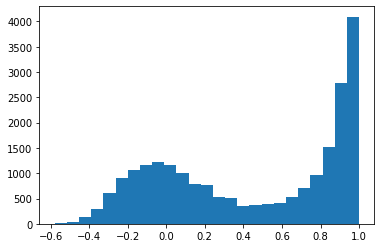

AUC score is 0.9258503331297072  while binary score is 0.7496406755300036 and the confusion matrix is [[ 5578  5554]
 [   20 11112]] on dev loader
Model is saved after 50000 iterations 
OCloss is 0.32180956962478596 and BCEloss is 0.538626188906533 and MNRloss is 0.0 and Cosloss is 0.1415585722096725  and time taken is 77557.65913152695 after 50000 iterations
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
image file is truncated
Something went wrong with the image of id 247087
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
image file is trunc

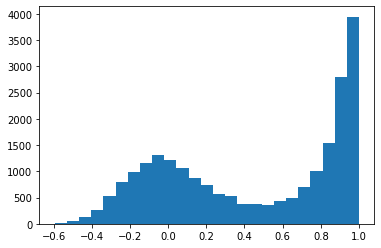

AUC score is 0.9328905263511051  while binary score is 0.7518864534674812 and the confusion matrix is [[ 5624  5508]
 [   16 11116]] on dev loader
Model is saved after 100000 iterations 
OCloss is 0.31195738282081265 and BCEloss is 0.5369502808130726 and MNRloss is 0.0 and Cosloss is 0.13851435675799717  and time taken is 154970.74119377136 after 100000 iterations
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
image file is truncated
Something went wrong with the image of id 154842.0
image file is truncated
Something went wrong with the image of id 247087.0
image file is truncated
Something went wrong with the image of id 154842.0
image file is truncated
Something went wrong with the image of id 154842.0
cannot identify image file '/home/ckm/visualqatickets/superuser/Data/images/1141373_2.png'
cannot identify image file '/home/ckm/visualqatickets/superu

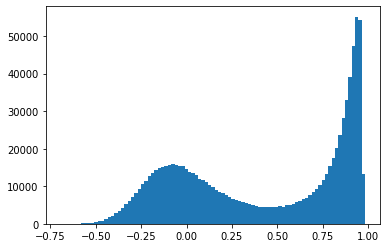

AUC and Bin_acc after training 1 on train dataloader is (0.9301026252592359, 0.7684317227712446) and confusion matrix is [[247868 212343]
 [   798 459415]]
    0 iterations have been done in 0.6501374244689941 seconds
/home/ckm/anaconda3/envs/visualqa/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ckm/anaconda3/envs/visualqa/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ckm/anaconda3/envs/visualqa/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ckm/anaconda3/envs/visualqa/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

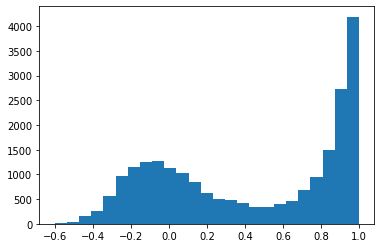

AUC and Bin_acc after training 1 on dev dataloader is (0.9279507377232272, 0.7745688106360044) and the confusion matris is [[ 6140  4992]
 [   27 11105]]
Model is saved after 1 epochs 


In [42]:
#Overall parameters in model
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
train_model(train_loader,model,1)

# Evaluator

## Binary Classification Evaluator

In [ ]:
# from . import SentenceEvaluator
import logging
import os
import csv
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from sklearn.metrics import average_precision_score
import numpy as np
from typing import List
# from ..readers import InputExample


logger = logging.getLogger(__name__)


In [ ]:
class BinaryClassificationEvaluator():
    """
    Evaluate a model based on the similarity of the embeddings by calculating the accuracy of identifying similar and
    dissimilar sentences.
    The metrics are the cosine similarity as well as euclidean and Manhattan distance
    The returned score is the accuracy with a specified metric.
    The results are written in a CSV. If a CSV already exists, then values are appended.
    The labels need to be 0 for dissimilar pairs and 1 for similar pairs.
    :param sentences1: The first column of sentences
    :param sentences2: The second column of sentences
    :param labels: labels[i] is the label for the pair (sentences1[i], sentences2[i]). Must be 0 or 1
    :param name: Name for the output
    :param batch_size: Batch size used to compute embeddings
    :param show_progress_bar: If true, prints a progress bar
    :param write_csv: Write results to a CSV file
    """

    def __init__(self,
                 dataset,
                 name: str = '',
                 batch_size: int = 32,
                 show_progress_bar: bool = False,
                 write_csv: bool = True
                 ):
        
        self.dataset = dataset
        self.labels = list()
        self.write_csv = write_csv
        self.name = name
        self.batch_size = batch_size
        self.dataloader = DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers = 8,
            shuffle = True
        )

        if show_progress_bar is None:
            show_progress_bar = (logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG)
        self.show_progress_bar = show_progress_bar

        self.csv_file = "binary_classification_evaluation" + ("_"+name if name else '') + "_results.csv"
        self.csv_headers = ["epoch", "steps",
                            "cosine_acc", "cosine_acc_threshold", "cosine_f1", "cosine_precision", "cosine_recall", "cosine_f1_threshold", "cosine_average_precision",
                            "manhatten_acc", "manhatten_acc_threshold", "manhatten_f1", "manhatten_precision", "manhatten_recall", "manhatten_f1_threshold", "manhatten_average_precision",
                            "eucledian_acc", "eucledian_acc_threshold", "eucledian_f1", "eucledian_precision", "eucledian_recall", "eucledian_f1_threshold", "eucledian_average_precision"]


    # @classmethod
    # def from_input_examples(cls, examples: List[InputExample], **kwargs):
    #     sentences1 = []
    #     sentences2 = []
    #     scores = []

    #     for example in examples:
    #         sentences1.append(example.texts[0])
    #         sentences2.append(example.texts[1])
    #         scores.append(example.label)
    #     return cls(sentences1, sentences2, scores, **kwargs)

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:

        if epoch != -1:
            if steps == -1:
                out_txt = f" after epoch {epoch}:"
            else:
                out_txt = f" in epoch {epoch} after {steps} steps:"
        else:
            out_txt = ":"

        logger.info("Binary Accuracy Evaluation of the model on " + self.name + " dataset" + out_txt)
        
        embeddings1 = list()
        embeddings2 = list()

        with torch.no_grad():
            model.eval()
            for i, batch in enumerate(self.dataloader):
                images = batch["image"]
                label = batch["label"]
                label = label.float()
                token = batch["token"]
                
                # print(images,label,token)

                images[0],images[1] = images[0].to(device),images[1].to(device)
                token[0],token[1] = token[0].to(device), token[1].to(device)
                label = label.to(device)
                
                # compute the model output
                yhat1 = model(images[0], token[0])
                yhat2 = model(images[1],token[1])

                for j in yhat1:
                    embeddings1.append(j.cpu().detach().numpy())
                for j in yhat2:
                    embeddings2.append(j.cpu().detach().numpy())
                for j in label:
                    self.labels.append(float(j))
                
                if(i%30==0 and i!=0):
                    print(f'Completed {i} iterations')

        cosine_scores = 1-paired_cosine_distances(embeddings1, embeddings2)
        manhattan_distances = paired_manhattan_distances(embeddings1, embeddings2)
        euclidean_distances = paired_euclidean_distances(embeddings1, embeddings2)


        labels = np.asarray(self.labels)

        file_output_data = [epoch, steps]

        main_score = None
        for name, scores, reverse in [['Cosine-Similarity', cosine_scores, True], ['Manhatten-Distance', manhattan_distances, False], ['Euclidean-Distance', euclidean_distances, False]]:
            acc, acc_threshold = self.find_best_acc_and_threshold(scores, labels, reverse)
            f1, precision, recall, f1_threshold = self.find_best_f1_and_threshold(scores, labels, reverse)
            ap = average_precision_score(labels, scores * (1 if reverse else -1))

            logger.info("Accuracy with {}:           {:.2f}\t(Threshold: {:.4f})".format(name, acc * 100, acc_threshold))
            logger.info("F1 with {}:                 {:.2f}\t(Threshold: {:.4f})".format(name, f1 * 100, f1_threshold))
            logger.info("Precision with {}:          {:.2f}".format(name, precision * 100))
            logger.info("Recall with {}:             {:.2f}".format(name, recall * 100))
            logger.info("Average Precision with {}:  {:.2f}\n".format(name, ap * 100))

            file_output_data.extend([acc, acc_threshold, f1, precision, recall, f1_threshold, ap])

            if main_score is None: #Use AveragePrecision with Cosine-Similarity as main score
                main_score = ap

        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            if not os.path.isfile(csv_path):
                with open(csv_path, mode="w", encoding="utf-8") as f:
                    writer = csv.writer(f)
                    writer.writerow(self.csv_headers)
                    writer.writerow(file_output_data)
            else:
                with open(csv_path, mode="a", encoding="utf-8") as f:
                    writer = csv.writer(f)
                    writer.writerow(file_output_data)

        return main_score

    @staticmethod
    def find_best_acc_and_threshold(scores, labels, high_score_more_similar: bool):
        # assert len(scores) == len(labels)
        rows = list(zip(scores, labels))

        rows = sorted(rows, key=lambda x: x[0], reverse=high_score_more_similar)

        max_acc = 0
        best_threshold = -1

        positive_so_far = 0
        remaining_negatives = sum(labels == 0)

        for i in range(len(rows)-1):
            score, label = rows[i]
            if label == 1:
                positive_so_far += 1
            else:
                remaining_negatives -= 1

            acc = (positive_so_far + remaining_negatives) / len(labels)
            if acc > max_acc:
                max_acc = acc
                best_threshold = (rows[i][0] + rows[i+1][0]) / 2

        return max_acc, best_threshold

    @staticmethod
    def find_best_f1_and_threshold(scores, labels, high_score_more_similar: bool):
        # assert len(scores) == len(labels)

        scores = np.asarray(scores)
        labels = np.asarray(labels)

        rows = list(zip(scores, labels))

        rows = sorted(rows, key=lambda x: x[0], reverse=high_score_more_similar)

        best_f1 = best_precision = best_recall = 0
        threshold = 0
        nextract = 0
        ncorrect = 0
        total_num_duplicates = sum(labels)

        for i in range(len(rows)-1):
            score, label = rows[i]
            nextract += 1

            if label == 1:
                ncorrect += 1

            if ncorrect > 0:
                precision = ncorrect / nextract
                recall = ncorrect / total_num_duplicates
                f1 = 2 * precision * recall / (precision + recall)
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

        return best_f1, best_precision, best_recall, threshold

In [ ]:
dev_BCEvaluator = BinaryClassificationEvaluator(dev_dataset,batch_size=BATCH_SIZE,show_progress_bar=True)
os.makedirs(folder+'/dev',exist_ok = True)
dev_BCEvaluator(model,output_path=folder+'/dev')

In [ ]:
train_BCEvaluator = BinaryClassificationEvaluator(train_dataset,batch_size=BATCH_SIZE,show_progress_bar=True)
os.makedirs(folder+'/train',exist_ok = True)
train_BCEvaluator(model,output_path=folder+'/train')

## Information retreival evaluator

In [ ]:
import torch
import logging
from tqdm import tqdm, trange
import os
import numpy as np
from typing import List, Tuple, Dict, Set

In [ ]:
class infodataset(Dataset):
    def __init__(self,qr,qr_idx,img_dir,transform = None):
        self.qr = qr
        self.qr_idx = qr_idx
        self.img_dir = img_dir
        self.transform = transform

    def image_adder(self,id1):
        img_id1 = list()
        if((self.qr.at[id1,'Attachments'])!=None):
            for i in self.qr.at[id1,'Attachments']:
                try:
                    img_path = os.path.join(self.img_dir,i)
                    img = Image.open(img_path).convert('RGB')
                    if(self.transform):
                        img = self.transform(img)
                        img.permute_(2,0,1)
                    img_id1.append(img)
                except Exception as e: 
                    print(e)
        else:
            img_id1.append(torch.zeros(3,224,224))

        # Work on this, for few examples, it is still saying list index out of range
        if(len(img_id1)==0):
            # print('No attachments found for id {}'.format(id1))
            print(f'Something went wrong with the image of id {id1}')
            img_id1.append(torch.zeros(3,224,224))

        return img_id1
    
    def __getitem__(self,idx):
        id1 = self.qr_idx[idx]
        img_id1 = self.image_adder(id1)

        # print(len(img_id1))

        # print('Printing id1 {} and len {} and id2 {} and len {} '.format(
        #     id1,len(img_id1),
        #     id2, len(img_id2)
        # ))

        # print('Printing id1 shape {} and id2  shape {}'.format(
        #     img_id1[0].shape,
        #     img_id2[0].shape
        # ))        

        sample = {
            'image': img_id1[0]    #Currently taking only one input image
        }

        t1 = '[CLS]' + self.qr.loc[id1,'Title'] + ' ' + ' '.join(self.qr.loc[id1,'Tags']) + ' ' + self.qr.loc[id1,'Text'] + '[SEP]'
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        t1_token = tokenizer.tokenize(t1)
        indexed_t1 = tokenizer.convert_tokens_to_ids(t1_token)
        
        while(len(indexed_t1)<512):
            indexed_t1.append(0)
        
        ten_t1 = torch.tensor(indexed_t1)[:512]
        
        try:
            sample["token"] = ten_t1 # torch.Size([batch_size, 512])
        except Exception as e:
            print(e)
        
        return sample

    def __len__(self):
        return len(self.qr_idx)

In [ ]:
class InformationRetreivalEvaluator():
    def __init__(self,
                 qr,
                 queries: Dict[str, str],  #qid => query
                 corpus: Dict[str, str],  #cid => doc
                 relevant_docs: Dict[str, Set[str]],  #qid => Set[cid]
                 corpus_chunk_size: int = 50000,
                 mrr_at_k: List[int] = [10],
                 ndcg_at_k: List[int] = [10],
                 accuracy_at_k: List[int] = [1, 3, 5, 10],
                 precision_recall_at_k: List[int] = [1, 3, 5, 10],
                 map_at_k: List[int] = [100],
                 show_progress_bar: bool = False,
                 batch_size: int = 32,
                 name: str = '',
                 write_csv: bool = True
                 ):
        
        self.qr = qr
        self.queries_ids = []
        for qid in queries:
            if qid in relevant_docs and len(relevant_docs[qid]) > 0:
                self.queries_ids.append(qid)

        self.queries = [queries[qid] for qid in self.queries_ids]

        self.corpus_ids = list(corpus.keys())
        self.corpus = [corpus[cid] for cid in self.corpus_ids]

        self.relevant_docs = relevant_docs
        self.corpus_chunk_size = corpus_chunk_size
        self.mrr_at_k = mrr_at_k
        self.ndcg_at_k = ndcg_at_k
        self.accuracy_at_k = accuracy_at_k
        self.precision_recall_at_k = precision_recall_at_k
        self.map_at_k = map_at_k

        self.show_progress_bar = show_progress_bar
        self.batch_size = batch_size
        self.name = name
        self.write_csv = write_csv

        if name:
            name = "_" + name

        self.csv_file: str = "Information-Retrieval_evaluation" + name + "_results.csv"
        self.csv_headers = ["epoch", "steps"]


        for k in accuracy_at_k:
            self.csv_headers.append("Accuracy@{}".format(k))

        for k in precision_recall_at_k:
            self.csv_headers.append("Precision@{}".format(k))
            self.csv_headers.append("Recall@{}".format(k))

        for k in mrr_at_k:
            self.csv_headers.append("MRR@{}".format(k))

        for k in ndcg_at_k:
            self.csv_headers.append("NDCG@{}".format(k))

        for k in map_at_k:
            self.csv_headers.append("MAP@{}".format(k))
    
    def __call__(self,model : BridgeModel,output_path: str = None,epoch: int = -1, steps: int = -1) ->float:
        if epoch != -1:
            out_txt = " after epoch {}:".format(epoch) if steps == -1 else " in epoch {} after {} steps:".format(epoch, steps)
        else:
            out_txt = ":"

        logger.info("Information Retrieval Evaluation on " + self.name + " dataset" + out_txt)

        max_k = max(max(self.mrr_at_k), max(self.ndcg_at_k), max(self.accuracy_at_k), max(self.precision_recall_at_k), max(self.map_at_k))

        query_embeddings = self.get_embeddings(model,self.qr,self.queries_ids)

        queries_result_list = [[] for _ in range(len(query_embeddings))]

        itr = range(0, len(self.corpus), self.corpus_chunk_size)

        if self.show_progress_bar:
            itr = tqdm(itr, desc='Corpus Chunks')

        #Iterate over chunks of the corpus
        for corpus_start_idx in itr:
            corpus_end_idx = min(corpus_start_idx + self.corpus_chunk_size, len(self.corpus))

            #Encode chunk of corpus
            sub_corpus_embeddings = self.get_embeddings(model,self.qr,self.corpus_ids[corpus_start_idx:corpus_end_idx])

            #Compute cosine similarites
            cos_scores = pytorch_cos_sim(query_embeddings, sub_corpus_embeddings)
            del sub_corpus_embeddings

            #Get top-k values
            cos_scores_top_k_values, cos_scores_top_k_idx = torch.topk(cos_scores, min(max_k, len(cos_scores[0])), dim=1, largest=True, sorted=False)
            cos_scores_top_k_values = cos_scores_top_k_values.cpu().tolist()
            cos_scores_top_k_idx = cos_scores_top_k_idx.cpu().tolist()
            del cos_scores

            for query_itr in range(len(query_embeddings)):
                for sub_corpus_id, score in zip(cos_scores_top_k_idx[query_itr], cos_scores_top_k_values[query_itr]):
                    corpus_id = self.corpus_ids[corpus_start_idx+sub_corpus_id]
                    queries_result_list[query_itr].append({'corpus_id': corpus_id, 'score': score})


        #Compute scores
        scores = self.compute_metrics(queries_result_list)

        #Output
        self.output_scores(scores)


        # logger.info("Queries: {}".format(len(self.queries)))
        # logger.info("Corpus: {}\n".format(len(self.corpus)))

        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            if not os.path.isfile(csv_path):
                fOut = open(csv_path, mode="w", encoding="utf-8")
                fOut.write(",".join(self.csv_headers))
                fOut.write("\n")

            else:
                fOut = open(csv_path, mode="a", encoding="utf-8")

            output_data = [epoch, steps]
            for k in self.accuracy_at_k:
                output_data.append(scores['accuracy@k'][k])

            for k in self.precision_recall_at_k:
                output_data.append(scores['precision@k'][k])
                output_data.append(scores['recall@k'][k])

            for k in self.mrr_at_k:
                output_data.append(scores['mrr@k'][k])

            for k in self.ndcg_at_k:
                output_data.append(scores['ndcg@k'][k])

            for k in self.map_at_k:
                output_data.append(scores['map@k'][k])

            fOut.write(",".join(map(str,output_data)))
            fOut.write("\n")
            fOut.close()

        return scores['map@k'][max(self.map_at_k)]


    def compute_metrics(self, queries_result_list: List[object]):
        # Init score computation values
        num_hits_at_k = {k: 0 for k in self.accuracy_at_k}
        precisions_at_k = {k: [] for k in self.precision_recall_at_k}
        recall_at_k = {k: [] for k in self.precision_recall_at_k}
        MRR = {k: 0 for k in self.mrr_at_k}
        ndcg = {k: [] for k in self.ndcg_at_k}
        AveP_at_k = {k: [] for k in self.map_at_k}

        # Compute scores on results
        for query_itr in range(len(queries_result_list)):
            query_id = self.queries_ids[query_itr]

            # Sort scores
            top_hits = sorted(queries_result_list[query_itr], key=lambda x: x['score'], reverse=True)
            query_relevant_docs = self.relevant_docs[query_id]

            # Accuracy@k - We count the result correct, if at least one relevant doc is accross the top-k documents
            for k_val in self.accuracy_at_k:
                for hit in top_hits[0:k_val]:
                    if hit['corpus_id'] in query_relevant_docs:
                        num_hits_at_k[k_val] += 1
                        break

            # Precision and Recall@k
            for k_val in self.precision_recall_at_k:
                num_correct = 0
                for hit in top_hits[0:k_val]:
                    if hit['corpus_id'] in query_relevant_docs:
                        num_correct += 1

                precisions_at_k[k_val].append(num_correct / k_val)
                recall_at_k[k_val].append(num_correct / len(query_relevant_docs))

            # MRR@k
            for k_val in self.mrr_at_k:
                for rank, hit in enumerate(top_hits[0:k_val]):
                    if hit['corpus_id'] in query_relevant_docs:
                        MRR[k_val] += 1.0 / (rank + 1)
                        break

            # NDCG@k
            for k_val in self.ndcg_at_k:
                predicted_relevance = [1 if top_hit['corpus_id'] in query_relevant_docs else 0 for top_hit in top_hits[0:k_val]]
                true_relevances = [1] * len(query_relevant_docs)

                ndcg_value = self.compute_dcg_at_k(predicted_relevance, k_val) / self.compute_dcg_at_k(true_relevances, k_val)
                ndcg[k_val].append(ndcg_value)

            # MAP@k
            for k_val in self.map_at_k:
                num_correct = 0
                sum_precisions = 0

                for rank, hit in enumerate(top_hits[0:k_val]):
                    if hit['corpus_id'] in query_relevant_docs:
                        num_correct += 1
                        sum_precisions += num_correct / (rank + 1)

                avg_precision = sum_precisions / min(k_val, len(query_relevant_docs))
                AveP_at_k[k_val].append(avg_precision)

        # Compute averages
        for k in num_hits_at_k:
            num_hits_at_k[k] /= len(self.queries_ids)

        for k in precisions_at_k:
            precisions_at_k[k] = np.mean(precisions_at_k[k])

        for k in recall_at_k:
            recall_at_k[k] = np.mean(recall_at_k[k])

        for k in ndcg:
            ndcg[k] = np.mean(ndcg[k])

        for k in MRR:
            MRR[k] /= len(self.queries_ids)

        for k in AveP_at_k:
            AveP_at_k[k] = np.mean(AveP_at_k[k])


        return {'accuracy@k': num_hits_at_k, 'precision@k': precisions_at_k, 'recall@k': recall_at_k, 'ndcg@k': ndcg, 'mrr@k': MRR, 'map@k': AveP_at_k}


    def output_scores(self, scores):
        for k in scores['accuracy@k']:
            logger.info("Accuracy@{}: {:.2f}%".format(k, scores['accuracy@k'][k]*100))

        for k in scores['precision@k']:
            logger.info("Precision@{}: {:.2f}%".format(k, scores['precision@k'][k]*100))

        for k in scores['recall@k']:
            logger.info("Recall@{}: {:.2f}%".format(k, scores['recall@k'][k]*100))

        for k in scores['mrr@k']:
            logger.info("MRR@{}: {:.4f}".format(k, scores['mrr@k'][k]))

        for k in scores['ndcg@k']:
            logger.info("NDCG@{}: {:.4f}".format(k, scores['ndcg@k'][k]))

        for k in scores['map@k']:
            logger.info("MAP@{}: {:.4f}".format(k, scores['map@k'][k]))


    @staticmethod
    def compute_dcg_at_k(relevances, k):
        dcg = 0
        for i in range(min(len(relevances), k)):
            dcg += relevances[i] / np.log2(i + 2)  #+2 as we start our idx at 0
        return dcg
    
    def get_embeddings(self,model,qr,qr_idx):
        info_dataset = infodataset(qr,qr_idx,img_dir,transform = transform_pipe)
        info_loader = DataLoader(
            info_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            num_workers = 8,
            )
        
        embeddings = list()
        since = time.time()
        for i,batch in enumerate(info_loader):
            model.eval()

            text = batch['token']
            images = batch['image']

            text,images = torch.tensor(text).to(device), torch.tensor(images).to(device)

            with torch.no_grad():
                yhat = model.forward(images,text)
            
            for j in yhat:
                embeddings.append(j.cpu().detach().numpy())
            
            if(i%40==0):
                print(f'{i} iterations hase been completed, and model is running for {time.time()-since}')
        
        return embeddings


In [ ]:
with open(folder_quora+'/devinfo_100.txt','rb') as a:
    queries_dev = pickle.load(a)
    rel_docs_dev= pickle.load(a)

with open(folder_quora+'/testinfo_100.txt','rb') as a:
    queries_test= pickle.load(a)
    rel_docs_test= pickle.load(a)

with open(folder_quora+'/traininfo_100.txt','rb') as a:
    queries_train= pickle.load(a)
    rel_docs_train= pickle.load(a)

In [ ]:
def corpus(qr):
    corpus = dict()
    for i in qr.index.values:
        corpus[i] = 'I dont care'
    return corpus

In [ ]:
train_inforet = InformationRetreivalEvaluator(train_qr,queries_train,corpus(train_qr),rel_docs_train)
os.makedirs(folder+'/train',exist_ok=True)
train_inforet(model,folder+'/train')

In [ ]:
dev_inforet = InformationRetreivalEvaluator(pd.concat([train_qr,dev_qr]),queries_dev,corpus(train_qr),rel_docs_dev)
os.makedirs(folder+'/dev',exist_ok=True)
dev_inforet(model,folder+'/dev')